# CLIPSeg zero-shot detection with Hugging Face Transformers

Using Hugging Face Transformers, we can easily download and run a pre-trained CLIPSeg model on your images. We first start by installing transformers.

In [1]:
!pip install -q transformers

To download the model, simply instantiate it.

In [2]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Now we can load an image to try out the segmentation. We'll choose a picture of a delicious breakfast taken by [Calum Lewis](https://unsplash.com/@calumlewis).

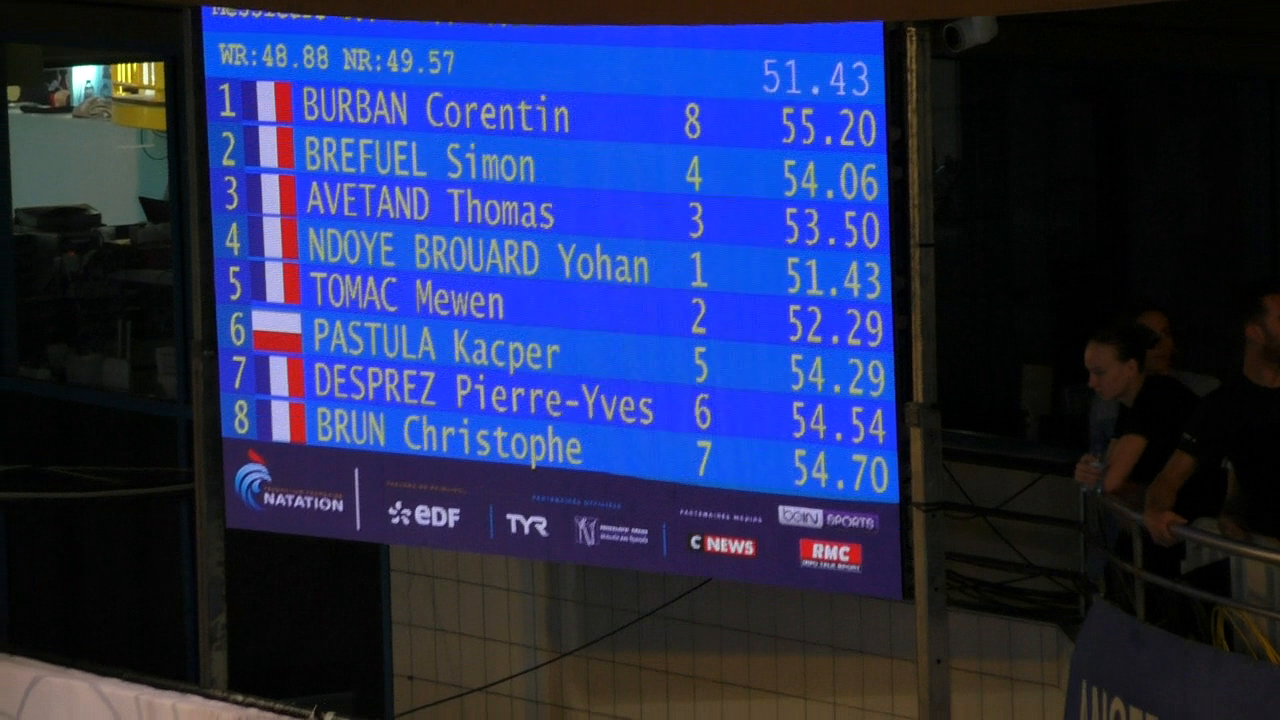

In [4]:
image = Image.open("../data/natation/000000.png")
image

## Text prompting

Let’s start by defining some text categories we want to segment. Here we put a description of a scoreboard

In [5]:
prompts = ["A swimming scoreboard is a rectangular panel that shows important information about a swimming competition. It uses bright LED lights to provide real-time updates on the progress of the race. The scoreboard is divided into several sections, each displaying different information about the race, including the name of the event, the swimmers' names, lane assignments, countries, times, and finishing order."]

Now that we have our inputs, we can process them and input them to the model.

In [6]:
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(0)

In [7]:
def crop_save_image(original_image, preds, thresh=0.5):
  
  mask = np.array(torch.sigmoid(preds) > thresh, dtype=np.uint8)
  height, width, channels = np.array(original_image).shape

  # Resize the image
  mask = cv2.resize(mask, (width, height))

  # Find the bounding box coordinates
  x, y, w, h = cv2.boundingRect(mask)

  # Crop original image
  original_image = np.array(original_image)
  cropped_image = original_image[y:y+h, x:x+w, :]

  _, ax = plt.subplots(1, 2, figsize=(12, 6))
  [a.axis('off') for a in ax.flatten()]
  ax[0].imshow(original_image)
  ax[1].imshow(mask)
  plt.show()

  return cropped_image

Finally, let’s visualize the output. We show the activations for the textual prompt.

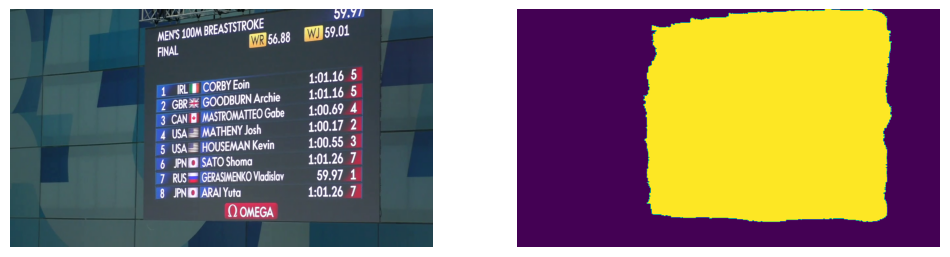

In [8]:
for path in glob("../data/natation/[0-9]*.png"):
  image = Image.open(path)
  inputs = processor(text=prompts, images=[image], padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits
  # Crop image
  cropped_image = crop_save_image(image, preds, thresh=0.5)
  break
  # Convert the image to the RGB color space
  cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  # Save the image to disk
  cv2.imwrite("text_prompt_" + path.split('/')[-1], cropped_image)

We see that we can already have a good representation of what we are looking for using only the textual description of the scoreboard.

## Visual prompting

We can also use images as the input prompts (i.e. in place of the textual prompt). This can be especially useful if it's not easy to describe the thing you want to segment.

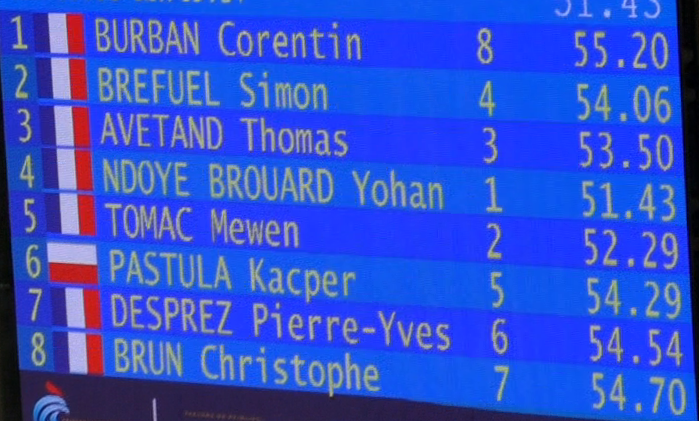

In [12]:
prompt = Image.open("../data/natation/ROI/CLIP_visual_prompt/scoreboard.png")
prompt

In [18]:
prompt = np.array(prompt)[:,:, 0:3]

We can now process the input image and prompt image and input them to the model.

In [25]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

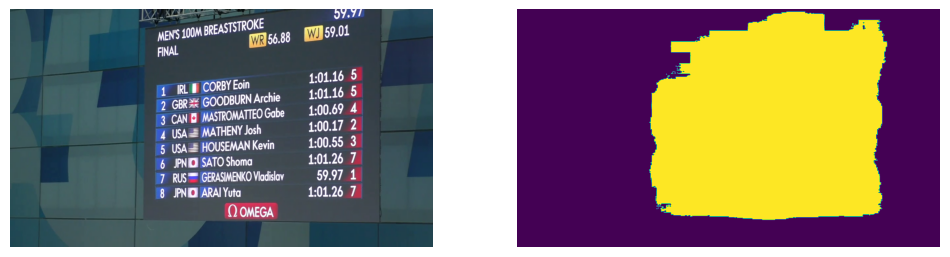

In [26]:
for path in glob("../data/natation/[0-9]*.png"):
  image = Image.open(path)

  encoded_image = processor(images=[image], return_tensors="pt")
  encoded_prompt = processor(images=[prompt], return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
  preds = outputs.logits.unsqueeze(1)
  preds = torch.transpose(preds, 0, 1)

  # Crop image
  cropped_image = crop_save_image(image, preds[0], thresh=0.5)
  break

  # Convert the image to the RGB color space
  cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  # Save the image to disk
  cv2.imwrite("visual_prompt_" + path.split('/')[-1], cropped_image)